In [2]:
import theano.tensor as T
from theano import function
from theano import pp

# Note: the default data type without the 'd' prefix is float.
x = T.dscalar('x')
y = T.dscalar('y')

# Alternatives:
# 1. x, y = T.dscalars(2)
# 2. x, y = T.dscalars('x', 'y')
#
# Note that the output of `pp` will be ugly in case (1).

z = x + y
f = function([x, y], z)

pp(z)

'(x + y)'

In [3]:
# Properties of Theano classes.

from pprint import pprint

pprint(vars(x))
print(vars(x.type))

# Use this to get the data type of a variable.
print(x.type.dtype)

{'auto_name': 'auto_3',
 'index': None,
 'name': 'x',
 'owner': None,
 'tag': scratchpad{'trace': [('<ipython-input-2-cfa939c54768>', 6, '<module>', "x = T.dscalar('x')")]},
 'type': TensorType(float64, scalar)}
{'broadcastable': (), 'name': None, 'numpy_dtype': dtype('float64'), 'sparse_grad': False, 'dtype': 'float64'}
float64


In [4]:
# Matrix computations.

x, y = T.dmatrices('x', 'y')
z = x + y
f = function([x, y], z)

print(pp(z))
f([[1, 2], [3, 4]], [[1, 0], [0, 1]])

(x + y)


array([[ 2.,  2.],
       [ 3.,  5.]])

In [5]:
# A somewhat less trivial example.

a, b = T.vectors('a', 'b')
out = (a + b) ** 2
f = function([a, b], out)

print(pp(out))
f([1, 2, 3], [4, 5, 6])

((a + b) ** TensorConstant{2})


array([ 25.,  49.,  81.])

<IPython.core.display.SVG object>


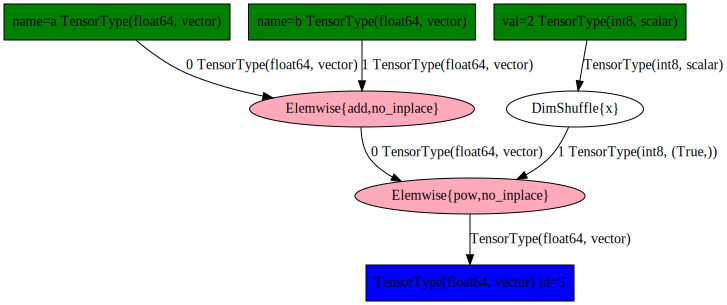

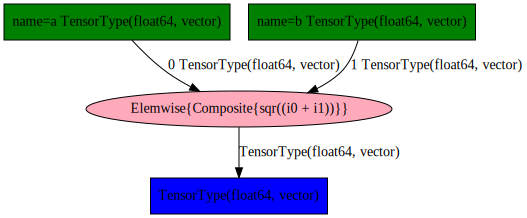

In [6]:
# To get pydot to work for Python 3.4, I used
# sudo pip install git+https://github.com/nlhepler/pydot

from theano.printing import pydotprint 
from IPython.display import display, Image, SVG

# Display as SVG.

# The unoptimized graph.
img = SVG(pydotprint(out, return_image=True, format='svg'))
print(img)
display(SVG(pydotprint(out, return_image=True, format='svg')))
# The optimized graph.
display(SVG(pydotprint(f, return_image=True, format='svg')))

# Display as PNG.
# display(Image(pydotprint(out, return_image=True, format='png'), retina=True))